# Data reduction interlude: Combining images

An important part of reducing astronomical images is combining calilbration images. Using single images for calibration introduces unnecessary noise in the final image. The practical effect of that noise is to make it impossible to see faint objects and increases the error in the measurements you can make.

The bulk of this will end up being about how to reject bad pixels in calibration images, typically caused by cosmic rays.

In [1]:
from __future__ import print_function, division

import numpy as np 

%matplotlib inline 
import matplotlib.pyplot as plt

from ccdproc import ImageFileCollection

In [2]:
def plot_colored_by_mask(values, mask):
    x = np.arange(len(values))
    plt.plot(x[mask], values[mask], 'ro', label='Rejected values')
    plt.plot(x[~mask], values[~mask], 'go', label='Good values')
    mean_of_good = np.mean(values[~mask])
    plt.xlim(-1, len(values))
    plt.plot([-1, len(values)], [mean_of_good, mean_of_good], 
             'g', label='Average of good values')
    median = np.median(values)
    plt.plot([1, len(values)], [median, median], label='Median of all values')
    plt.legend()

In [3]:
loc = '/Users/mcraig/Documents/Research/SA112-SF1/2013-07-03'

In [4]:
ic = ImageFileCollection(loc)

In [5]:
darks = []

for d in ic.data(imagetyp='DARK', exptime=30):
    darks.append(d)

In [6]:
darks = np.array(darks)
darks.shape

(10, 2048, 3085)

In [7]:
print(darks[:, 315, 333])

[4685 2978 2981 2977 2979 3055 2978 3008 3002 3015]


(-1, 10)

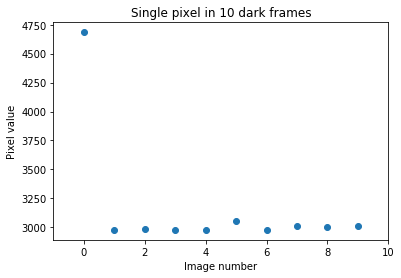

In [8]:
pix_with_cr = darks[:, 315, 333]

plt.plot(pix_with_cr, 'o')
plt.title('Single pixel in 10 dark frames')
plt.xlabel('Image number')
plt.ylabel('Pixel value')
plt.xlim(-1, 10)

# Potential ways to remove the effect of the bad pixel

1. Use the average value, hope there are enough images to dilute the effect of one bad pixel.
2. Use the *median* value.
3. Take the average but exclude the pixel value in some images:
    + exclude the highest and lowest pixel value.
    + exclude all pixels above a pre-set value and/or below a pre-set value.
    + exclude any pixel more than some number of standard deviations from a central value (the median or the average)
    
For this pixel in this set of images, let's try each of the options above.

## mean (average) vs median

Everyone is familiar with the mean (or average): add the values and divide by the number of values. The *median* is the middle value of a set of numbers. For example, the average of the list of numbers 1, 2, 5, 5, 100 is 22.6, but the median is 5 because it is the middle value when the list is sorted by value.

For the problem pixel above, the mean and median values are marked on the graph below.

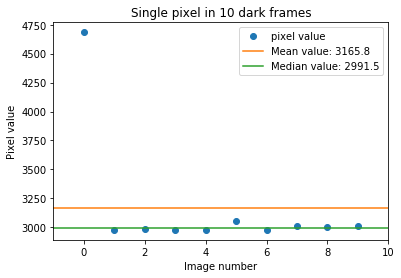

In [9]:
plt.plot(pix_with_cr, 'o', label='pixel value')
plt.title('Single pixel in 10 dark frames')
plt.xlabel('Image number')
plt.ylabel('Pixel value')

# Change x limits so it is easier to see end values
x_limits = [-1, 10]

# Calculate the mean
mean = pix_with_cr.mean()

# Calculate the median
median = np.median(pix_with_cr
                  )
plt.xlim(*x_limits)
plt.plot(x_limits, [mean, mean], label='Mean value: {}'.format(mean))
plt.plot(x_limits, [median, median], label='Median value: {}'.format(median))
# plt.ylim(2970, 3050)
plt.legend()

The median is clearly a much better indicator of the typical pixel value than the mean. The first conclusion you might draw is that when combining image one should use the median rather than the mean.

The disadvantage of the median is that the error (noise) in the combined image is larger when the images are combined with the median than when they are combined with the mean. The error in the median is roughly 1.48 times larger than the error in the average.

## Image clipping: remove extreme values and average the rest

There is a way to get the best of both worlds: the lower error one gets from the average but the rejection of outlying pixels one obtains from the median.

The idea is to do image combination in two steps:

+ Identify the pixels that are extreme.
+ Average the values of the remaining pixels that do not have extreme values.

There are several ways to identify extreme pixel values. Each is described below.

### Clipping method 1: pixels above/below fixed values

The simplest form of clipping is to identify all values above a fixed value or below a (presumably different) fixed value as extreme.

For example, if we chose the maximum "good" value to be 3,500 and the minimum good value to be 2,980, then the *red* points below would be excluded.

The values chosen here are somewhat arbitrary. The upper value was chosen to exclude the cosmic ray in the first image, and the lower value was chosen to be near the minimum of the dark pixel values.

Text(0.5,1,'Rejection by fixed min/max values')

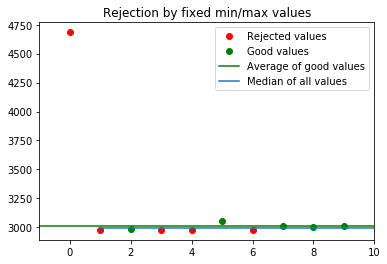

In [10]:
mask = (pix_with_cr > 3500) | (pix_with_cr < 2980)

plot_colored_by_mask(pix_with_cr, mask)
plt.title('Rejection by fixed min/max values')

The method is simple but has several disadvantages:

+ It is hard to pick meaningful values the cutoffs without looking at the data.
+ The appropriate value to use may differ from night to night 
+ The appropriate value will be different for different image types (*all* values in a flat should be well above 3,500!). 

In `ccdproc` this method of combining is called `minmax_clipping`.

### Clipping method 2: Reject the highest and lowest values

This method of clipping, like the first method, is straightforward. The highest and lowest values are excluded. If these values are typical of the rest of the values this will not affect the mean much; if they are extreme values (like the one in the first image) they are rejected, which is what we want.

Text(0.5,1,'Rejection of highest and lowest values')

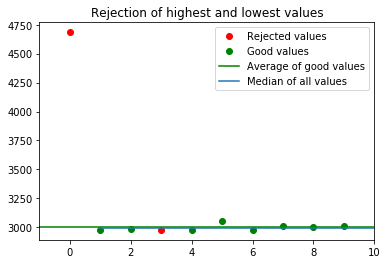

In [11]:
mask = (pix_with_cr == pix_with_cr.max()) | (pix_with_cr == pix_with_cr.min())

plot_colored_by_mask(pix_with_cr, mask)
plt.title('Rejection of highest and lowest values')

This is an improvement over the first method in that you do not have to work out the cutoff values. However, there are a couple of disadvantages:

+ Two values are always rejected even if none of them actually need to be.
+ For pixels without cosmic rays (i.e. 99.999% of them) the combined result will be noisier than it needs to be because you are rejecting good pixels.

In `ccdproc` this method of clipping is called `clip_extrema`.

### Clipping method 3: Reject the outlying pixels (sigma clipping)

Visually it is clear which pixel should be excluded: it is the one in the first image, whose value is very far off from the rest.

One way to do that computationally is to calculate a "typical" value for a group of pixels, and reject any values that are "too far" from that typical value.

From above, the median is clearly a better choice for calculating the typical value for the pixels when one of the pixels has an extreme value.

For calculating the how "far" each pixel is from the typical value there are two options. One could measure it as a number of standard deviations (rejecting anything more than 3 or 5 standard deviations from the typical value, say). The problem is that one outlying pixel can lead to a really large standard deviation. Instead, it is better to use the *median absolute deviation* as the measure of how scattered the data points are.



Text(0.5,1,'Rejection sigma clipping')

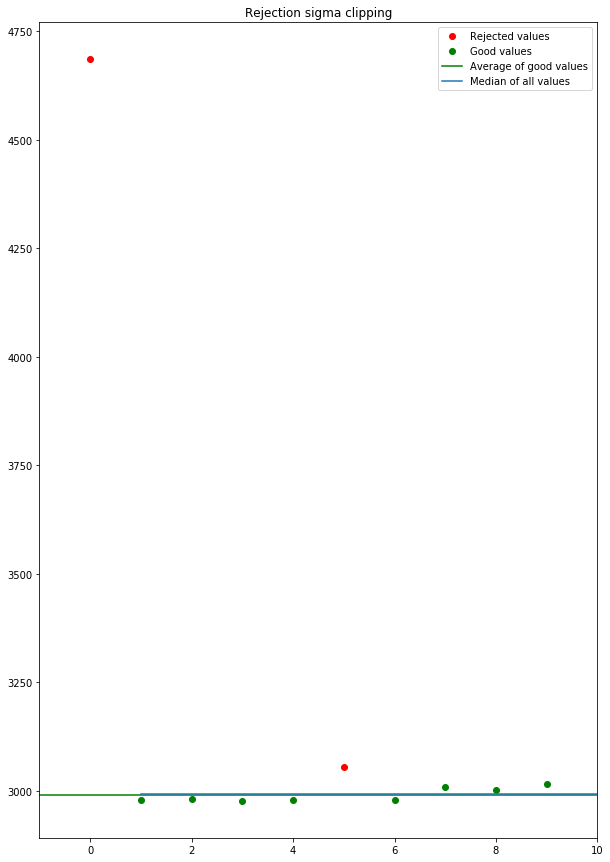

In [12]:
from astropy.stats import median_absolute_deviation

# Calculate the typical value
median = np.median(pix_with_cr)

# Calculate the scatter in the points
median_deviation = median_absolute_deviation(pix_with_cr)

# Calculate how many "error bars" each point is from the typical value
n_error_bars = np.abs((pix_with_cr - median) / median_deviation)

# Reject any pixels more than 5 "error bars" from typical value
mask = n_error_bars > 4

plt.figure(figsize=(10, 15))
plot_colored_by_mask(pix_with_cr, mask)
plt.title('Rejection sigma clipping')

#### This is the clipping method you should use.

In `ccdproc` it is called `sigma_clipping`.